In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import math

(train, test) , info = tfds.load('mnist', split =['train', 'test'], 
                                 as_supervised=True , with_info=True)

In [4]:
def preprocess(data):
    # DATA TYPE
    data = data.map(lambda img, target: (tf.cast(img, tf.float32)))
    # SHAPE
    data = data.map(lambda img: tf.reshape(img, (28 ** 2,)))
    # NORMALIZE
    data = data.map(lambda img: ((img - 128.)/64.))
    # DATAFLOW PREP
    data = data.cache()
    data = data.shuffle(1000, seed=42)
    data = data.batch(32)
    data = data.prefetch(10)
    return data


train = train.apply(preprocess)
test  = test.apply(preprocess)

In [257]:
from tqdm import tqdm



class LeakyRelu:
    def __init__(self, alpha=0.2):
        self.alpha = alpha
    
    
    def __call__(self, x):
        return tf.cast(x >= 0, tf.float32) * x + tf.cast(x < 0, tf.float32) * x * self.alpha
    
    
    def inv(self, x):
        return tf.cast(x >= 0, tf.float32) * x + tf.cast(x < 0, tf.float32) * x * (1/self.alpha)



class InvDense(tf.keras.layers.Layer):
    def __init__(self, n_units, activation=LeakyRelu, **kwargs):
        super().__init__()
        self.n_units = n_units
        self.activation = activation()
    
    
    def build(self, n_inputs):
        self.n_inputs = n_inputs[1]
        limit = math.sqrt(6 / (self.n_inputs + self.n_units))
        self.W = tf.random.uniform((self.n_units, self.n_inputs), -limit, limit)
        self.b = tf.zeros(shape=(1, self.n_units))
        self.is_built = True
    
    
    def call(self, x):
        z = tf.transpose(self.W @ tf.transpose(x)) + self.b
        return self.activation(z)
    
    
    def inv(self, y):
        W_T = tf.transpose(self.W)
        #W_T = self.W
        #W_inv = tf.linalg.inv(W_T @ self.W) @ W_T
        W_inv = W_T
        #W_inv = tf.linalg.inv(self.W @ W_T) @ self.W
        #W_inv = tf.stop_gradient(W_inv)
        z = self.activation.inv(y)
        x = tf.transpose(W_inv @ tf.transpose(z - self.b))
        return x
        


class IAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.layer_0 = InvDense(28**2 - 1)
        self.layer_1 = InvDense(28**2 - 1)
        self.layer_2 = InvDense(28**2 - 1)
        self.layer_3 = InvDense(28**2 - 1)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    
    #@tf.function
    def call(self, x):
        for layer in self.layers:
            x = layer(x)
            #plt.imshow(x.numpy()[0,...].reshape((28, 28)), cmap='binary')
            #plt.show()
        return x
    
    
    #@tf.function
    def inv(self, x):
        for layer in self.layers[::-1]:
            x = layer.inv(x)
            #plt.imshow(x.numpy()[0,...].reshape((28, 28)), cmap='binary')
            #plt.show()
        return x
    
    
    #@tf.function
    def full(self, x):
        y = self(x)
        x_inv = self.inv(y)
        return x_inv
    
    
    #@tf.function
    def loss(self, x):
        mse = tf.keras.losses.MeanSquaredError()
        return mse(x, self.full(x))
    
    
    def step(self, x):
        with tf.GradientTape() as tape:
            loss = self.loss(x)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
    
    
    def train(self, epochs, dataset):
        with tqdm(total=epochs) as bar:
            bar.set_description('JAZZ')
            for epoch in range(epochs):
                for x in dataset:
                    self.step(x)
                bar.update(1)


model = IAE()

In [258]:
x = next(iter(test))
print(model.loss(x))
model.train(10, train)

2023-02-07 18:17:04.312840: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-02-07 18:17:04.312961: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


tf.Tensor(876.6137, shape=(), dtype=float32)


JAZZ: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.52s/it]


2023-02-07 18:19:49.549786: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-02-07 18:19:49.549876: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


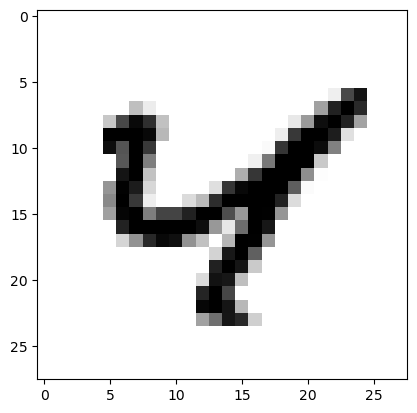

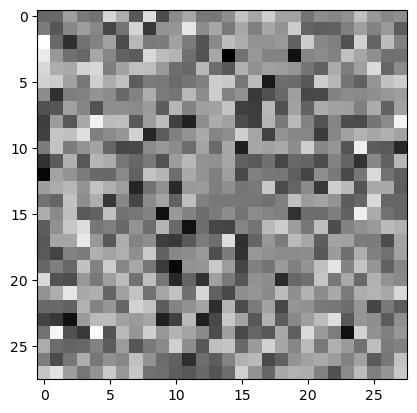

In [259]:
from matplotlib import pyplot as plt
%matplotlib inline

x = next(iter(test))
plt.imshow(x.numpy()[0,...].reshape((28, 28)), cmap='binary')
plt.show()
x_inv = model.full(x)
#print(model.loss(x))
plt.imshow(x_inv.numpy()[0,...].reshape((28, 28)), cmap='binary')
plt.show()

#17402983000000
#19822497000000